In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn
from dgl.nn import EdgeWeightNorm, GraphConv
from dgl.data import DGLDataset
import mysql.connector
import dgl.data
import numpy as np
import pandas as pd
import os
from dgl import save_graphs, load_graphs
import networkx as nx
import dgl.function as fn
import matplotlib.pyplot as plt
import random

# Connect to database

In [8]:
cnx = mysql.connector.connect(user='david', password='daviddung1993',
                          host='127.0.0.1',
                          database='computervision')
cursor = cnx.cursor()
headers = {"x-api-key": "M7HSjQNeTfai6l7JUiDZB8XYc85BHnHt3R0NXSEd"}


# Create dataset

In [161]:
cursor.execute("select p.PaperID from Papers p, authoredBy a where p.PaperID = a.PaperID and p.Leaf = False and p.Pub_Year = 2022 and a.AuthoredByID in (select distinct(a.AuthoredByID) as authorID from Papers p, authoredBy a where p.PaperID = a.PaperID and p.Leaf = FALSE and p.Pub_Year != 2022 and a.AuthoredByID != 0) group by p.PaperID")
test_set = [x[0] for x in cursor.fetchall()]

ProgrammingError: 2055: Cursor is not connected

# DGL Dataset classes

In [3]:
class PaperDataset(DGLDataset):
    def __init__(self, nodes_data, edges_data):
        super().__init__(name='paper_dataset')
        self.nodes_data = nodes_data
        self.edges_data = edges_data

    def process(self):
        node_features = torch.from_numpy(self.nodes_data['Year'].to_numpy())
        node_labels = torch.from_numpy(self.nodes_data['PaperID'].astype('category').cat.codes.to_numpy())
        edge_features = torch.from_numpy(self.edges_data['Weight'].to_numpy())
        edges_src = torch.from_numpy(self.edges_data['Src'].to_numpy())
        edges_dst = torch.from_numpy(self.edges_data['Dst'].to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=self.nodes_data.shape[0])
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels
        self.graph.edata['weight'] = edge_features

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = self.nodes_data.shape[0]
        n_train = int(n_nodes * 0.6)
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train:n_train + n_val] = True
        test_mask[n_train + n_val:] = True
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

In [4]:
class AuthorDataset(DGLDataset):
    def __init__(self, nodes_data, edges_data):
        self.nodes_data = nodes_data
        self.edges_data = edges_data
        super().__init__(name='author_dataset')

    def process(self):
        #node_features = torch.from_numpy(self.nodes_data['Year'].to_numpy())
        node_features = torch.from_numpy(np.zeros((len(self.nodes_data), 1)))
        node_labels = torch.from_numpy(self.nodes_data['AuthorID'].astype('category').cat.codes.to_numpy())
        edge_features = torch.from_numpy(self.edges_data['Count'].to_numpy()).type(torch.int32)
        edges_src = torch.from_numpy(self.edges_data['RefAuthor'].astype(int).to_numpy())
        edges_dst = torch.from_numpy(self.edges_data['Author'].astype(int).to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=self.nodes_data.shape[0])
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels
        self.graph.edata['weight'] = edge_features

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = self.nodes_data.shape[0]
        n_train = int(n_nodes * 0.6)
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train:n_train + n_val] = True
        test_mask[n_train + n_val:] = True
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

In [156]:
cnx.close()

# Paper Graph

In [9]:
graph_size = 50000
cursor.execute("select r.ReferenceID as rID, p.PaperID as pID from Papers p, referencedBy r where p.Leaf = False and p.Pub_Year < 2010 and r.ReferencedByID = p.PaperID and r.ReferenceID not like '11111%'")

# Fetch references (edges)
references_raw = cursor.fetchall()
references_df = pd.DataFrame(references_raw, columns=["ReferenceID","PaperID"])

# Fetch all papers (nodes)
cursor.execute("CREATE TEMPORARY TABLE temp_table AS (select p.PaperID as PaperID from Papers p, referencedBy r where p.Leaf = False and p.Pub_Year < 2013 and r.ReferencedByID = p.PaperID and r.ReferenceID not like '11111%' UNION select r.ReferenceID as PaperID from Papers p, referencedBy r where p.Leaf = False and p.Pub_Year < 2010 and r.ReferencedByID = p.PaperID and r.ReferenceID not like '11111%')")
cursor.execute("select * from temp_table")
all_papers_series = cursor.fetchall()
all_papers_remap_ids = {all_papers_series[x][0]: x for x in range(0, len(all_papers_series))}

# Remap the references to id
references_df = references_df.applymap(lambda x: all_papers_remap_ids[x])

# Fetch authors and remap to label
cursor.execute("select b.PaperID, b.AuthoredByID from authoredBy b, temp_table t where b.PaperID = t.PaperID")
authored_by_df = pd.DataFrame(cursor.fetchall(), columns=["PaperID", "AuthorID"])
feature_vector_df = pd.DataFrame(columns=authored_by_df["AuthorID"].unique())
authored_by_df["PaperID"] = authored_by_df["PaperID"].apply(lambda x: all_papers_remap_ids[x])

In [10]:
for idx, entry in enumerate(authored_by_df.iterrows()):
    if idx % 10 == 0:
        print(idx)
    feature_vector_df.loc[entry[1]["PaperID"], entry[1]["AuthorID"]] = 1

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [183]:
from scipy.sparse import csr_matrix

In [12]:
feature_vector_df

,145944053,1689198,1737505,1740591,2982295,1828610,2830546,49664054,1706958,1714335,...,47013198,4777285,93882234,1731709,48044592,69451391,3180815,1784705,2138026,2833202
0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN
10409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
10410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
10411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1


In [144]:
cursor.execute("Select p.PaperID as PaperID from Papers p where p.Leaf=False and p.Pub_Year < 2013")
len(cursor.fetchall())

1795

In [164]:
num_nodes = 5

# Labels for each node (in this example, each node has multiple labels)
labels = [
    ['Author 1', 'Author 3', 'Author 7'],
    ['Author 1', 'Author 2', 'Author 4'],
    ['Author 2', 'Author 3', 'Author 6'],
    ['Author 4', 'Author 5', 'Author 8'],
    ['Author 5', 'Author 6', 'Author 8']
]

# Create a pandas DataFrame with a column for each author
df = pd.DataFrame(columns=np.unique(np.concatenate(labels)))

# Set the entries corresponding to the labels to 1
#for i, node_labels in enumerate(labels):
#    df.loc[i, node_labels] = 1

# Convert the DataFrame to a NumPy array
multi_label_vector = df.to_numpy()

print(multi_label_vector)  # Output: array([[1., 0., 0., 1., 0., 0., 1., 0.],
                         #                [1., 1., 0., 1., 0., 0., 0., 0.],
                         #                [0., 1., 0., 0., 0., 1., 0., 0.],
                         #                [0., 0., 0., 0., 1., 0., 0., 1.],
                         #                [0., 0., 0., 0., 1., 1., 0., 1.]])

[]


# Initialize Graph

In [36]:
val_split = 0.2
random.seed(2)

In [111]:
if not os.path.isfile("./data2.bin"):
    added_labels = []
    cursor.execute("select a.AuthorID from Authors a")
    all_authors = cursor.fetchall()
    all_authors_index = [(x, all_authors[x][0]) for x in range(0, len(all_authors))]
    authors = pd.DataFrame(all_authors_index, columns=["key", "AuthorID"])
    max_id = authors["key"].max()
    complete_references_raw = pd.DataFrame({'key_x' : [],  "key_y" : [], "year": [], "PaperID": []})
    conc_list = []
    # Fetch data per year (otherwise it would crash)
    for year in range(2000,2010):
        print(year)
        cursor.execute(f"select a.AuthoredByID, a2.AuthoredByID, p.Pub_Year, p.PaperID from Papers p, authoredBy a, authoredBy a2, referencedBy b where p.PaperID = b.ReferencedByID and a.AuthoredByID != 0 and p.PaperID = a.PaperID and a2.AuthoredByID != 0 and p.Pub_Year = {year} and b.ReferenceID = a2.PaperID")
        entries = cursor.fetchall()
        entries_df = pd.DataFrame(entries, columns=["A", "B", "year", "PaperID"])
        temp = pd.merge(entries_df, authors, left_on="B", right_on="AuthorID")
        all_references = pd.merge(authors, temp, left_on="AuthorID", right_on="A")
        subset_all_references = all_references[["key_x", "key_y", "year", "PaperID"]]
        complete_references_raw = pd.concat([complete_references_raw, subset_all_references])

    # Choose latest papers with existing authors in the training as validation
    aggregated_references = complete_references_raw.groupby(["PaperID", "key_x", "year"], as_index=False).count()
    author_count = aggregated_references.groupby(["key_x"]).size().reset_index(name='count')
    author_count = author_count[author_count["count"] != 1]
    aggregated_references = pd.merge(aggregated_references, author_count, on="key_x")
    validation_subset_sample = random.sample(range(len(author_count)), int(val_split*len(author_count)))
    for val_id in validation_subset_sample:
        # Get latest paper of that author
        latest_paper_information = aggregated_references[aggregated_references["key_x"] == author_count.iloc[val_id]["key_x"]].sort_values("year").iloc[-1]
        val_author_id = latest_paper_information["key_x"]
        val_paper_id = latest_paper_information["PaperID"]
        val_author_label_id = authors[authors["key"] == val_author_id]["AuthorID"].values[0]
        added_labels.append(val_author_id)
        # Remap the id
        max_id += 1
        authors = pd.concat([authors, pd.DataFrame({"key": [max_id], "AuthorID": [val_author_label_id]})])
        aggregated_references.loc[(aggregated_references["PaperID"] == val_paper_id) & (aggregated_references["key_x"] == val_author_id), ["key_x"]] \
            = max_id
        aggregated_references.drop(aggregated_references.loc[(aggregated_references["PaperID"] == val_paper_id) & (aggregated_references["key_x"] != max_id)].index, inplace=True)


    complete_references_raw = complete_references_raw.groupby(["key_x", "key_y"]).size().reset_index(name='C')
    complete_references_raw = complete_references_raw.rename(columns={"key_x":"Author", "key_y":"RefAuthor", "C":"Count"})
    dataset = AuthorDataset(authors, complete_references_raw)
    graph = dataset[0]
    save_graphs("./data.bin", [graph])
else: # Load graph if exists
    glist, label_dict = load_graphs("./data.bin")
    graph = glist[0]

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009


In [100]:
print()

        key_x
190  450237.0


In [107]:
aggregated_references.drop(aggregated_references.loc[(aggregated_references["PaperID"] == val_paper_id) & (aggregated_references["key_x"] != max_id)].index, inplace=True)

In [113]:
aggregated_references.loc[(aggregated_references["PaperID"] == val_paper_id) & (aggregated_references["key_x"] != max_id)].index

Int64Index([], dtype='int64')

## Properties

In [61]:
print(f"Number of nodes: {graph.num_nodes()}")
print(f"Number of edges: {graph.num_edges()}")
in_degrees = graph.in_degrees().numpy()
out_degrees = graph.out_degrees().numpy()

Number of nodes: 733726
Number of edges: 25392667


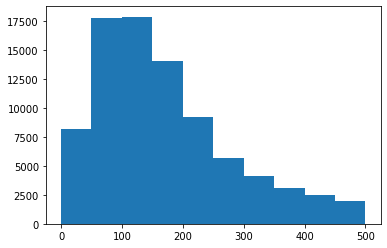

In [43]:
plt.hist(in_degrees[in_degrees != 0], range=(0,500))
plt.show()

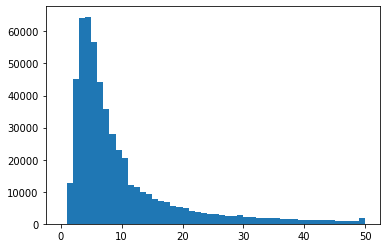

In [57]:
plt.hist(out_degrees[out_degrees != 0], range=(0,50), bins=50)
plt.show()

In [67]:
node_subset = random.sample(range(graph.num_nodes()), 4000)
sub_graph = graph.subgraph(node_subset)

# Graph Neural Network

In [73]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()

        self.conv1 = GraphConv(in_feats, hid_feats, allow_zero_in_degree=True, norm='none', weight=True, bias=True)
        self.conv2 = GraphConv(hid_feats, out_feats, allow_zero_in_degree=True, norm='none', weight=True, bias=True)

    def forward(self, graph, inputs, edge_weight):
        norm = EdgeWeightNorm(norm='both')
        norm_edge_weight = norm(graph, edge_weight)
        #print(norm_edge_weight)
        h = self.conv1(graph, inputs, edge_weight=norm_edge_weight)
        h = F.relu(h)
        h = self.conv2(graph, h, edge_weight=norm_edge_weight)
        return h

In [47]:
node_features = graph.ndata['feat'].float()
node_labels = graph.ndata['label']
train_mask = graph.ndata['train_mask']
valid_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
edge_weights = graph.edata['weight'].float()
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [48]:
def evaluate(model, graph, features, edge_weights, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features, edge_weights)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        print(indices)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [50]:
len(edge_weights)

29100277

In [51]:
model = GCN(in_feats=n_features, hid_feats=12, out_feats=n_labels)
opt = torch.optim.Adam(model.parameters())

for epoch in range(10000):
    model.train()
    # forward propagation by using all nodes
    logits = model(graph, node_features, edge_weights)
    # compute loss
    loss = F.cross_entropy(logits[train_mask], node_labels[train_mask].long())
    # compute validation accuracy
    acc = evaluate(model, graph, node_features, edge_weights, node_labels, valid_mask)
    print(acc)
    # backward propagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

    # Save model if necessary.  Omitted in this example.

RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 2153415372304 bytes. Error code 12 (Cannot allocate memory)

# Sample GNN

In [114]:
sample_g = dgl.graph(([1, 2, 2, 1, 1, 3, 3, 2, 3, 2, 5, 1, 2, 2, 1, 3, 2, 5],[0, 0, 1, 3, 4, 4, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11]))
sample_g.ndata['feat'] = torch.randn(12, 1)
sample_g.ndata['label'] = torch.tensor(list(range(8)) + [0, 7,1, 4, 7])
#sample_g.edata['weights'] = torch.tensor([2,2,1,1,1,3,1,1,1,3,1,1,1,1,1,1,1,1]).type(torch.float32)
sample_g.edata['weights'] = torch.tensor([2,2,1,1,1,3,1,1,3,3,1,3,3,3,3,3,3,3]).type(torch.float32)
t_mask = torch.zeros(12, dtype=torch.bool)
v_mask = torch.zeros(12, dtype=torch.bool)
t_mask[:8] = True
v_mask[8:] = True
sample_g.ndata['train_mask'] = t_mask
sample_g.ndata['val_mask'] = v_mask
sample_g.ndata['test_mask'] = v_mask
#sample_g = dgl.add_self_loop(sample_g)

TypeError: 'list' object cannot be interpreted as an integer

In [9]:
# Define the loss function
class BinaryCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(BinaryCrossEntropyLoss, self).__init__()
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, logits, labels):
        return self.loss_fn(logits, labels)

In [3]:
sample_g = dgl.graph(([2,2,3,3,2,3,6],[0,1,1,4,5,5,0]))
sample_g.ndata['feat'] = torch.randn(7, 2)
sample_g.ndata['label'] = torch.tensor([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1],[0,1,0,0,0,0]])
t_mask = torch.zeros(7, dtype=torch.bool)
v_mask = torch.zeros(7, dtype=torch.bool)
t_mask[:4] = True
v_mask[5:] = True
sample_g.ndata['train_mask'] = t_mask
sample_g.ndata['val_mask'] = v_mask
sample_g.ndata['test_mask'] = v_mask

In [4]:
sample_g.ndata['feat']

tensor([[ 1.2875,  1.3238],
        [ 1.4970,  0.2341],
        [ 1.3481,  0.1165],
        [-0.5130, -0.4312],
        [ 0.8833, -2.4597],
        [-2.0096,  0.0357],
        [-0.1836, -0.7578]])

In [5]:
graph2 = sample_g

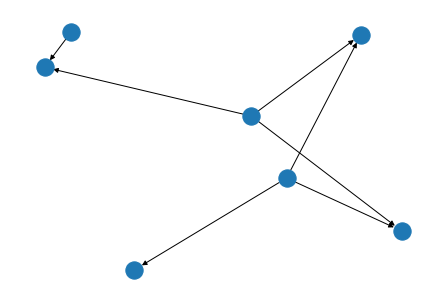

In [278]:
nx.draw(sample_g.to_networkx())

In [6]:
node_features = sample_g.ndata['feat']
node_labels = sample_g.ndata['label']
train_mask = sample_g.ndata['train_mask']
valid_mask = sample_g.ndata['val_mask']
#test_mask = sample_g.ndata['test_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)
#sample_g = dgl.add_self_loop(sample_g)

# Random Stuff

In [273]:
dataset2 = dgl.data.CiteseerGraphDataset()
print('Number of categories:', dataset2.num_classes)
graph2 = dataset2[0]
graph2.ndata['val_mask']

  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Number of categories: 6


tensor([False, False, False,  ..., False, False, False])

In [7]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        #self.conv1 = dglnn.SAGEConv(
        #    in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        #self.conv2 = dglnn.SAGEConv(
        #    in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')
        self.conv1 = GraphConv(in_feats, hid_feats, allow_zero_in_degree=True)
        self.conv2 = GraphConv(hid_feats, out_feats, allow_zero_in_degree=True)

    def forward(self, graph, inputs):
        norm = EdgeWeightNorm(norm='both')
        #norm_edge_weight = norm(graph, edge_weight)
        #print(norm_edge_weight)
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

# Create the model with given dimensions
#model = GCN(graph2.ndata['feat'].shape[1], 64, dataset2.num_classes)

In [280]:
graph2.edata['weights'].dtype

KeyError: 'weights'

In [63]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    #test_mask = g.ndata['test_mask']
    loss_fn = BinaryCrossEntropyLoss()
    for e in range(500):
        # Forward
        logits = model(g, features)
        # Compute prediction
        pred = logits
        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask].float())
        # Compute accuracy on training/validation/test
        #train_acc = (pred[train_mask].long() == labels[train_mask]).float().mean()
        train_acc = (logits[train_mask] > 0).long().eq(labels[train_mask]).float().mean()
        #val_acc = (pred[val_mask].long() == labels[val_mask]).float().mean()
        val_acc = (logits[g.ndata['val_mask']] > 0).long().eq(g.ndata['label'][g.ndata['val_mask']]).float().mean()
        #test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
        test_acc = 0
        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 10 == 0:
            print(f'Epoch {e}: loss={loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')
model = GCN(2, 8, 8)
train(g, model)

Epoch 0: loss=0.6948, train_acc=0.4688, val_acc=0.5625
Epoch 10: loss=0.6682, train_acc=0.6562, val_acc=0.6250
Epoch 20: loss=0.6434, train_acc=0.6719, val_acc=0.6250
Epoch 30: loss=0.6195, train_acc=0.6719, val_acc=0.6250
Epoch 40: loss=0.5971, train_acc=0.7031, val_acc=0.7500
Epoch 50: loss=0.5777, train_acc=0.7188, val_acc=0.8125
Epoch 60: loss=0.5610, train_acc=0.7188, val_acc=0.8125
Epoch 70: loss=0.5455, train_acc=0.7812, val_acc=0.8125
Epoch 80: loss=0.5312, train_acc=0.7969, val_acc=0.8125
Epoch 90: loss=0.5183, train_acc=0.7969, val_acc=0.8125
Epoch 100: loss=0.5066, train_acc=0.7969, val_acc=0.8125
Epoch 110: loss=0.4961, train_acc=0.7969, val_acc=0.8125
Epoch 120: loss=0.4863, train_acc=0.7969, val_acc=0.8125
Epoch 130: loss=0.4772, train_acc=0.8125, val_acc=0.8750
Epoch 140: loss=0.4687, train_acc=0.8125, val_acc=0.8750
Epoch 150: loss=0.4609, train_acc=0.8125, val_acc=0.8750
Epoch 160: loss=0.4537, train_acc=0.8125, val_acc=0.8750
Epoch 170: loss=0.4473, train_acc=0.8125, 

In [12]:
g = graph2

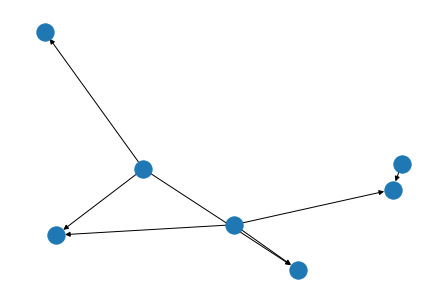

In [13]:
nx.draw(graph2.to_networkx())

In [110]:
# Create the graph and node features
g = dgl.DGLGraph()
num_papers = 400
num_authors = 200
g.add_nodes(num_papers)
#features = torch.randn(num_papers, 2)
features = torch.zeros(num_papers, 0)
# Define the labels for each node
labels = torch.randint(2, size=(num_papers, num_authors))
g.ndata['label'] = labels

# Add random edges to the graph
for i in range(num_papers):
    if i % 100 == 0:
        print(i)
    for j in range(i+1, num_papers):
        if random.random() < 0.1:  # 50% chance of adding an edge
            g.add_edge(j, i)

# Add the nodes and edges to the graph
#g.add_nodes(len(features))
g.ndata['feat'] = features
g.ndata['label'] = labels

# Split the data into train, validation, and test sets
t_mask = torch.zeros(len(features), dtype=torch.bool)
v_mask = torch.zeros(len(features), dtype=torch.bool)
t_mask[:25000] = True
v_mask[25000:] = True
g.ndata["train_mask"] = t_mask
g.ndata["val_mask"] = v_mask

0
100
200
300


In [95]:

nx.draw(g.to_networkx())
g.ndata['feat']

tensor([[-1.6765, -0.7956],
        [-0.2571, -1.2591],
        [-1.1323, -0.1018],
        ...,
        [-1.5830, -0.5672],
        [-1.1757, -0.5143],
        [-1.0874, -1.0603]])

Error in callback <function flush_figures at 0x7fa0c9389240> (for post_execute):



KeyboardInterrupt



In [106]:
g.ndata['feat']

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [113]:
import dgl
import torch
import torch.nn as nn

# Define the model
class GraphClassificationModel(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GraphClassificationModel, self).__init__()
        self.layers = nn.ModuleList([
            dgl.nn.GraphConv(in_dim, hidden_dim, allow_zero_in_degree=True),
            dgl.nn.GraphConv(hidden_dim, hidden_dim, allow_zero_in_degree=True),
            dgl.nn.GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)
        ])

    def forward(self, g, features):
        h = features
        for layer in self.layers:
            h = h.contiguous()
            h = layer(g, h)
        return h

# Define the loss function
class BinaryCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(BinaryCrossEntropyLoss, self).__init__()
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, logits, labels):
        return self.loss_fn(logits, labels)



# Initialize the model and the loss function
model = GraphClassificationModel(0, 8, 200)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(500):
    logits = model(g, g.ndata['feat'])
    loss = F.binary_cross_entropy_with_logits(logits[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']].float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
    # Evaluation loop
        with torch.no_grad():
            logits = model(g, g.ndata['feat'])
            train_acc = (logits[g.ndata['train_mask']] > 0).long().eq(g.ndata['label'][g.ndata['train_mask']]).float().mean()
            val_acc = (logits[g.ndata['val_mask']] > 0).long().eq(g.ndata['label'][g.ndata['val_mask']]).float().mean()
            print(f'Epoch {epoch}: loss={loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

# Test the model on the test set
#test_acc = (logits[g.ndata['test_mask']] > 0).long().eq(g.ndata['label'][g.ndata['test_mask']]).float().mean()
#print(f'Test accuracy: {test_acc:.4f}')


DGLError: [15:14:18] /opt/dgl/src/array/./check.h:38: Check failed: arrays[i].IsContiguous(): Expect U_data to be a contiguous tensor
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/dgl/libdgl.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x4f) [0x7fa0ecfa16ef]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/dgl/libdgl.so(dgl::aten::CheckContiguous(std::vector<dgl::runtime::NDArray, std::allocator<dgl::runtime::NDArray> > const&, std::vector<std::string, std::allocator<std::string> > const&)+0x127) [0x7fa0ed222d07]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/dgl/libdgl.so(+0x419d7b) [0x7fa0ed219d7b]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/dgl/libdgl.so(+0x41a891) [0x7fa0ed21a891]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/dgl/libdgl.so(DGLFuncCall+0x48) [0x7fa0ed269118]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/dgl/_ffi/_cy3/core.cpython-310-x86_64-linux-gnu.so(+0x14fa3) [0x7fa0eca14fa3]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/dgl/_ffi/_cy3/core.cpython-310-x86_64-linux-gnu.so(+0x1578b) [0x7fa0eca1578b]
  [bt] (7) /home/david/Work/TinyML/image_labeler_application/venv/local/bin/python(_PyObject_MakeTpCall+0x25b) [0x556b685797db]
  [bt] (8) /home/david/Work/TinyML/image_labeler_application/venv/local/bin/python(_PyEval_EvalFrameDefault+0x64f9) [0x556b68571e39]



In [99]:
g.ndata['feat']

tensor([[-1.6765, -0.7956],
        [-0.2571, -1.2591],
        [-1.1323, -0.1018],
        ...,
        [-1.5830, -0.5672],
        [-1.1757, -0.5143],
        [-1.0874, -1.0603]])

In [311]:
logits

tensor([[ 0.4759, -0.2498, -5.9102, -5.0863, -6.0688, -5.4875],
        [ 0.0931, -0.4158, -4.3912, -3.8085, -4.6465, -4.2222],
        [-0.9526, -0.8691, -0.2411, -0.3174, -0.7606, -0.7654],
        [-0.9526, -0.8691, -0.2411, -0.3174, -0.7606, -0.7654],
        [-0.2132, -0.5485, -3.1756, -2.7859, -3.5083, -3.2097],
        [ 0.0931, -0.4158, -4.3912, -3.8085, -4.6465, -4.2222],
        [-0.9526, -0.8691, -0.2411, -0.3174, -0.7606, -0.7654]])

In [304]:
num_nodes = 10
features = torch.randn(num_nodes, 2)

# Define the labels for each node
labels = torch.randint(2, size=(num_nodes, 8))
labels

tensor([[0, 0, 1, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 1, 0],
        [0, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 1, 1],
        [0, 1, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 1, 0, 1],
        [1, 0, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 0, 1, 0, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0]])